In [1]:
import pystac

items = pystac.ItemCollection.from_file("results.json")

In [4]:
red_uri = items[1].assets["B04"].href
nir_uri = items[1].assets["B8A"].href

In [5]:
import rioxarray

red = rioxarray.open_rasterio(red_uri, masked=True)
nir = rioxarray.open_rasterio(nir_uri, masked=True)


In [6]:
bbox = (629_000, 5_804_000, 639_000, 5_814_000)
red_clip = red.rio.clip_box(*bbox)
nir_clip = nir.rio.clip_box(*bbox)


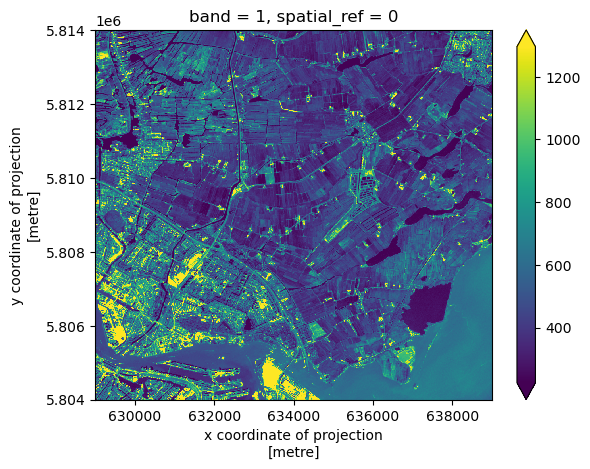

In [7]:
red_clip.plot(robust=True)

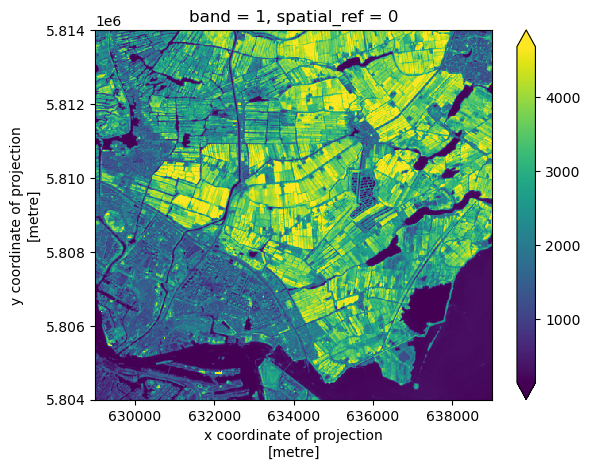

In [8]:
nir_clip.plot(robust=True)

In [9]:
print(red_clip.shape, nir_clip.shape)

(1, 1000, 1000) (1, 500, 500)


In [10]:
red_clip_matched = red_clip.rio.reproject_match(nir_clip)
print(red_clip_matched.shape)

(1, 500, 500)


In [11]:
ndvi = (nir_clip - red_clip_matched) / (nir_clip + red_clip_matched)
print(ndvi)

<xarray.DataArray (band: 1, y: 500, x: 500)>
array([[[ 0.7379576 ,  0.77153456,  0.54531944, ...,  0.39254385,
          0.49227372,  0.4465174 ],
        [ 0.7024894 ,  0.7074668 ,  0.3903298 , ...,  0.423283  ,
          0.4706971 ,  0.45964912],
        [ 0.6557818 ,  0.5610572 ,  0.46742022, ...,  0.4510345 ,
          0.43815723,  0.6005133 ],
        ...,
        [ 0.02391171,  0.21843003,  0.02479339, ..., -0.50923485,
         -0.53367877, -0.4955414 ],
        [ 0.11376493,  0.17681159, -0.1673566 , ..., -0.5221932 ,
         -0.5271318 , -0.4852753 ],
        [ 0.45398772, -0.00518135,  0.03346133, ..., -0.5019455 ,
         -0.4987013 , -0.49081364]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.29e+05 6.29e+05 6.29e+05 ... 6.39e+05 6.39e+05
  * y            (y) float64 5.814e+06 5.814e+06 ... 5.804e+06 5.804e+06
    spatial_ref  int64 0


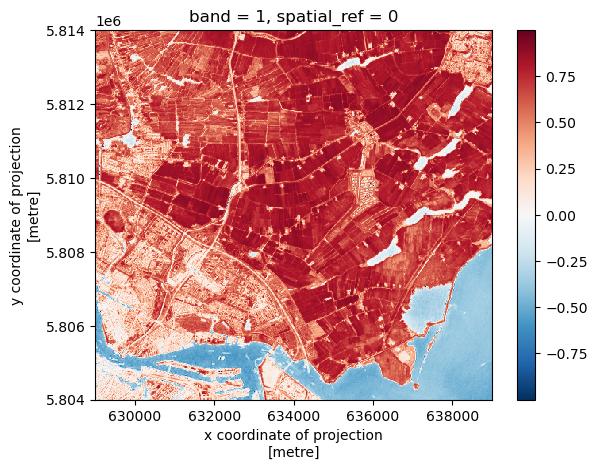

In [13]:
ndvi.plot()

(array([2.1000e+01, 1.2800e+02, 1.6076e+04, 1.3546e+04, 6.4030e+03,
        1.5811e+04, 2.4608e+04, 4.0979e+04, 8.2569e+04, 4.9858e+04]),
 array([-9.98647749e-01, -7.98825085e-01, -5.99002421e-01, -3.99179786e-01,
        -1.99357137e-01,  4.65512276e-04,  2.00288162e-01,  4.00110811e-01,
         5.99933445e-01,  7.99756110e-01,  9.99578774e-01]),
 <BarContainer object of 10 artists>)

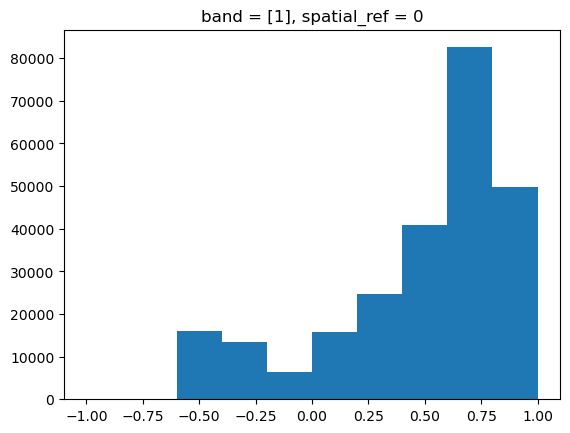

In [14]:
ndvi.plot.hist()

0.9995788
-0.99864775
1


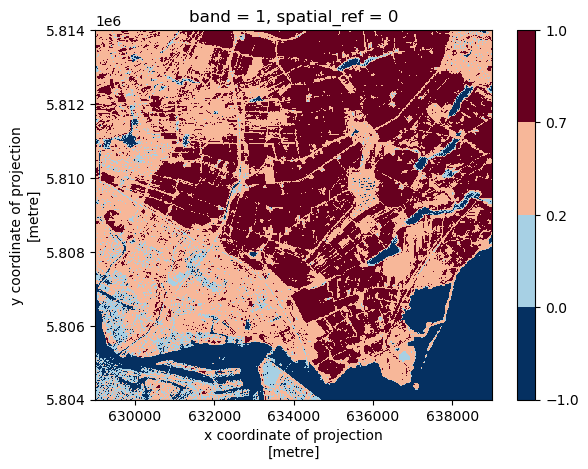

In [31]:
# Exercise: Explore NDVI Raster Values

print(ndvi.max().values)
print(ndvi.min().values)
print(ndvi.isnull().sum().values)
# 1. Max is 0.9995788, min is -0.99864775. There is a single null value.

ndvi.plot.hist(bins=50)
# 2. There are two clear peaks, and the left peak has values below it

bins = (-1, 0., 0.2, 0.7, 1)
ndvi.plot(levels=bins)

In [32]:
ndvi_nonan = ndvi.interpolate_na(dim="x")
ndvi_nonan.rio.to_raster("NDVI.tif")

In [36]:
import numpy as np
import xarray

ndvi_classified = xarray.apply_ufunc(
    np.digitize,
    ndvi_nonan,
    bins
)

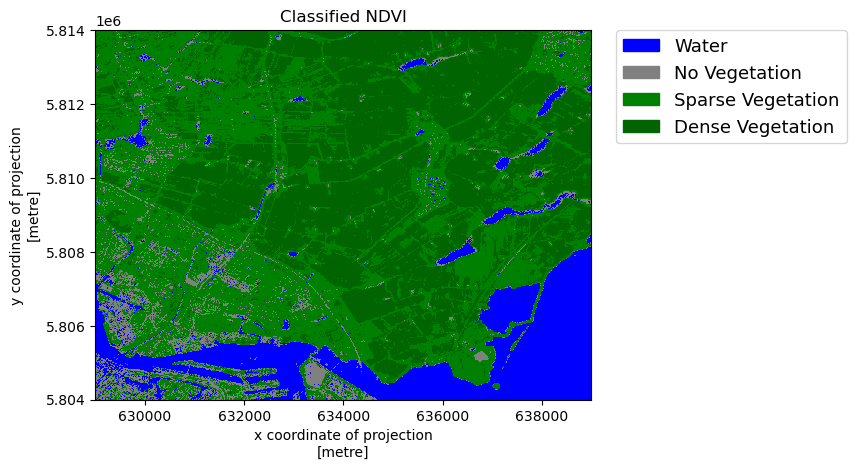

In [37]:
import earthpy.plot as ep
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

ndvi_colors = ["blue", "gray", "green", "darkgreen"]
ndvi_cmap = ListedColormap(ndvi_colors)

category_names = [
    "Water",
    "No Vegetation",
    "Sparse Vegetation",
    "Dense Vegetation"
]

category_indices = list(range(len(category_names)))

im = ndvi_classified.plot(cmap=ndvi_cmap, add_colorbar=False)
plt.title("Classified NDVI")
ep.draw_legend(im_ax=im, classes=category_indices, titles=category_names)

plt.savefig("NDVI_classified.png", bbox_inches="tight", dpi=300)

In [38]:
ndvi_classified.rio.to_raster("NDVI_classified.tif", dtype="int32")

red (1, 1000, 1000) <xarray.DataArray (band: 1, y: 1000, x: 1000)>
[1000000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.29e+05 6.29e+05 6.29e+05 ... 6.39e+05 6.39e+05
  * y            (y) float64 5.814e+06 5.814e+06 ... 5.804e+06 5.804e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    scale_factor:        1.0
    add_offset:          0.0
nir (1, 500, 500) <xarray.DataArray (band: 1, y: 500, x: 500)>
[250000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.29e+05 6.29e+05 6.29e+05 ... 6.39e+05 6.39e+05
  * y            (y) float64 5.814e+06 5.814e+06 ... 5.804e+06 5.804e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    scale_factor:        1.0
    add_offset:          0.0
-0.99864775
0.9995788


(array([1.2000e+01, 2.0000e+00, 2.0000e+00, 3.0000e+00, 2.0000e+00,
        8.0000e+00, 7.0000e+00, 4.0000e+00, 2.9000e+01, 8.0000e+01,
        5.5800e+02, 2.0930e+03, 3.1920e+03, 4.6700e+03, 5.5630e+03,
        7.6140e+03, 2.9020e+03, 1.3340e+03, 9.5700e+02, 7.3900e+02,
        8.1800e+02, 1.0210e+03, 1.2840e+03, 1.4820e+03, 1.7980e+03,
        2.1740e+03, 2.8470e+03, 3.2340e+03, 3.7030e+03, 3.8530e+03,
        4.2410e+03, 4.6100e+03, 4.8320e+03, 5.3200e+03, 5.6050e+03,
        6.2230e+03, 6.9630e+03, 7.9370e+03, 9.0210e+03, 1.0835e+04,
        1.2352e+04, 1.3883e+04, 1.5219e+04, 1.8287e+04, 2.2828e+04,
        2.5534e+04, 1.9329e+04, 4.9850e+03, 8.0000e+00, 2.0000e+00]),
 array([-9.98647749e-01, -9.58683193e-01, -9.18718696e-01, -8.78754139e-01,
        -8.38789642e-01, -7.98825085e-01, -7.58860588e-01, -7.18896031e-01,
        -6.78931534e-01, -6.38966978e-01, -5.99002421e-01, -5.59037924e-01,
        -5.19073367e-01, -4.79108840e-01, -4.39144313e-01, -3.99179786e-01,
        -3.592

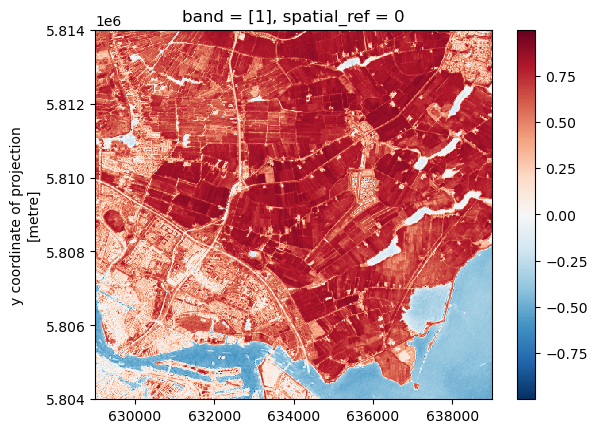

In [49]:
# Exercise: Compute the NDVI for the Texel island

# 2. Crop the two rasters using the following bounding box
ex_bbox = (610000, 5870000, 630000, 5900000)
ex_red_clip = red.rio.clip_box(*bbox)
ex_nir_clip = nir.rio.clip_box(*bbox)
print("red", ex_red_clip.shape, ex_red_clip)
print("nir", ex_nir_clip.shape, ex_nir_clip)

# 3. Compute the NDVI from the two raster layers
ex_red_clip_match = ex_red_clip.rio.reproject_match(ex_nir_clip)
ex_ndvi = (ex_nir_clip - ex_red_clip_match) / (ex_nir_clip + ex_red_clip_match)
print(ex_ndvi.min().values)
print(ex_ndvi.max().values)

# 4. Plot the NDVI map and export the NDVI as a GeoTiff
ex_ndvi.plot()
ex_ndvi.rio.to_raster("ex_ndvi.tif")

# 5. Compare the distributions of NDVI values for the two regions investigated
ex_ndvi.plot.hist(bins=50)